/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 6355 images belonging to 15 classes.
Found 270 images belonging to 15 classes.
87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/50
199/199 [==============================] - 109s 318ms/step - loss: 0.7491 - accuracy: 0.7975 - val_loss: 0.0628 - val_accuracy: 0.9889
Epoch 2/50
199/199 [==============================] - 29s 143ms/step - loss: 0.0335 - accuracy: 0.9948 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 3/50
199/199 [==============================] - 28s 142ms/step - loss: 0.0132 - accuracy: 0.9980 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/50
199/199 [==============================] - 28s 142ms/step - loss: 0.0107 - accuracy: 0.9980 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/50
199/199 [==============================] - 28s 141ms/step - loss: 0.0072 - accuracy: 0.9991 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 6/50
199/199 [==============================] - 28s 140ms/step - loss: 0.0189 - accuracy: 0.9942 - val_loss: 0.0027 - 

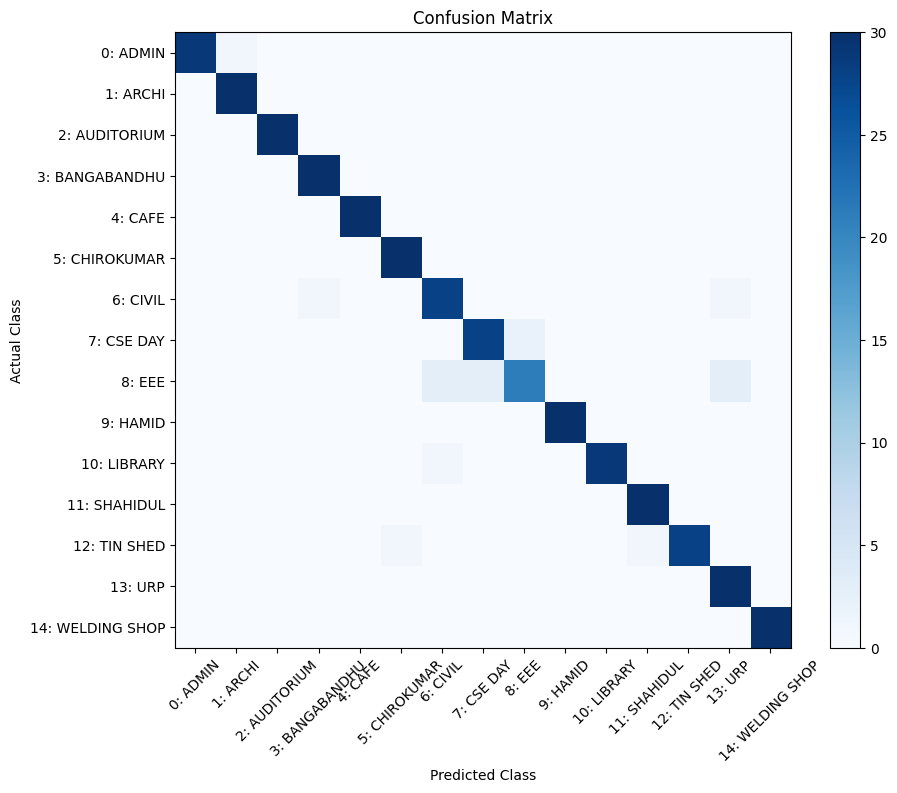

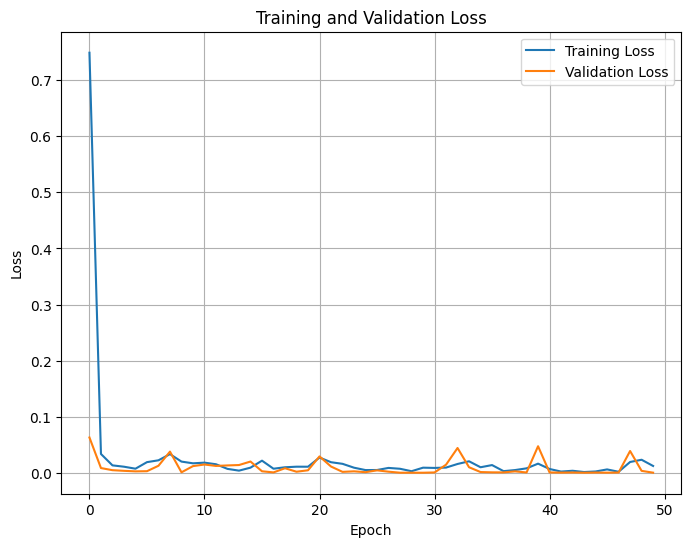

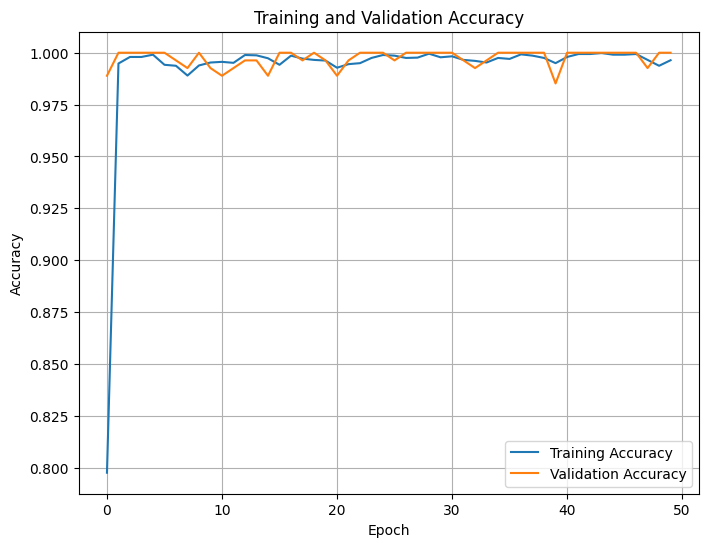

Class Precisions: [1.0, 0.967741935483871, 1.0, 0.967741935483871, 1.0, 0.967741935483871, 0.875, 0.9032258064516129, 0.9130434782608695, 1.0, 1.0, 0.967741935483871, 1.0, 0.8823529411764706, 1.0]
Class Recalls: [0.9666666666666667, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333333, 0.9333333333333333, 0.7, 1.0, 0.9666666666666667, 1.0, 0.9333333333333333, 1.0, 1.0]
Class F1 Scores: [0.983050847457627, 0.9836065573770492, 1.0, 0.9836065573770492, 1.0, 0.9836065573770492, 0.9032258064516129, 0.9180327868852459, 0.7924528301886793, 1.0, 0.983050847457627, 0.9836065573770492, 0.9655172413793104, 0.9375, 1.0]
Micro-Precision: 0.9622222222222222
Micro-Recall: 0.9622222222222222
Micro-F1: 0.9622222222222222
Top-1 Accuracy: 0.9622222222222222
Top-5 Accuracy: 0.9977777777777778


In [1]:
#"Model Training"

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/training', target_size=(150, 150), batch_size=32, class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory('/kaggle/input/dataset-ruet/basedata/basedata/validation', target_size=(150, 150), batch_size=32, class_mode='categorical')

inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(inception_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(15, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_generator, epochs=50, validation_data=valid_generator)

model_dir = '/kaggle/working/model_study/INCEPTION V3 '
os.makedirs(model_dir, exist_ok=True)

model.save(os.path.join(model_dir, 'my_model_Inception_V3.h5'))

loss_values = np.array(history.history['loss']).reshape(-1, 1)
accuracy_values = np.array(history.history['accuracy']).reshape(-1, 1)
val_loss_values = np.array(history.history['val_loss']).reshape(-1, 1)
val_accuracy_values = np.array(history.history['val_accuracy']).reshape(-1, 1)

file_name = 'INCEPTION V3.csv'

results = np.column_stack((loss_values, accuracy_values, val_loss_values, val_accuracy_values))

csv_file_path = os.path.join(model_dir,file_name)
np.savetxt(csv_file_path, results, delimiter=',', header='Loss,Accuracy,Validation Loss,Validation Accuracy', comments='')

print("Loss values:", loss_values)
print("Accuracy values:", accuracy_values)
print("Validation loss values:", val_loss_values)
print("Validation accuracy values:", val_accuracy_values)
print("CSV file saved at:", csv_file_path)


#"Testing/Prediction"

test_data_dir = '/kaggle/input/dataset-ruet/basedata/basedata/testing'
test_images = []
ground_truth_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        img = image.load_img(image_path, target_size=(224, 224))  
        img_array = image.img_to_array(img)
        img_array /= 255.0
        test_images.append(img_array)
        ground_truth_labels.append(class_name)

test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

label_to_index = {label: i for i, label in enumerate(train_generator.class_indices)}
ground_truth_indices = np.array([label_to_index[label] for label in ground_truth_labels])

class_names = list(train_generator.class_indices.keys())
class_numbers = [label_to_index[label] for label in class_names]

conf_matrix = confusion_matrix(ground_truth_indices, predicted_labels)

accuracy = accuracy_score(ground_truth_indices, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(train_generator.class_indices))
plt.xticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks], rotation=45)
plt.yticks(tick_marks, [f"{class_numbers[i]}: {class_names[i]}" for i in tick_marks])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()


#"Performance Matrix Calculation"

from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

precisions = []
recalls = []
f1_scores = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

print("Class Precisions:", precisions)
print("Class Recalls:", recalls)
print("Class F1 Scores:", f1_scores)

from sklearn.metrics import precision_score, recall_score, f1_score

micro_precision = precision_score(ground_truth_indices, predicted_labels, average='micro')
micro_recall = recall_score(ground_truth_indices, predicted_labels, average='micro')
micro_f1 = f1_score(ground_truth_indices, predicted_labels, average='micro')
print("Micro-Precision:", micro_precision)
print("Micro-Recall:", micro_recall)
print("Micro-F1:", micro_f1)

top_1_accuracy = accuracy_score(ground_truth_indices, predicted_labels)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]  
top_5_accuracy = np.mean(np.array([ground_truth_indices[i] in top_5_predictions[i] for i in range(len(ground_truth_indices))]))

print("Top-1 Accuracy:", top_1_accuracy)
print("Top-5 Accuracy:", top_5_accuracy)

In [3]:
#"Testing/Prediction"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score
import os

test_data_dir = '/kaggle/input/dataset-ruet/basedata/basedata/testing'
test_images = []
ground_truth_labels = []
for class_name in os.listdir(test_data_dir):
    class_dir = os.path.join(test_data_dir, class_name)
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        img = image.load_img(image_path, target_size=(224, 224))  
        img_array = image.img_to_array(img)
        img_array /= 255.0
        test_images.append(img_array)
        ground_truth_labels.append(class_name)

test_images = np.array(test_images)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

label_to_index = {label: i for i, label in enumerate(train_generator.class_indices)}
ground_truth_indices = np.array([label_to_index[label] for label in ground_truth_labels])

class_names = list(train_generator.class_indices.keys())
class_numbers = [label_to_index[label] for label in class_names]

conf_matrix = confusion_matrix(ground_truth_indices, predicted_labels)

accuracy = accuracy_score(ground_truth_indices, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

top_1_accuracy = accuracy_score(ground_truth_indices, predicted_labels)
top_5_predictions = np.argsort(predictions, axis=1)[:, -5:]  
top_5_accuracy = np.mean(np.array([ground_truth_indices[i] in top_5_predictions[i] for i in range(len(ground_truth_indices))]))

print("Accuracy:", accuracy)
print("Top-1 Accuracy:", top_1_accuracy)
print("Top-5 Accuracy:", top_5_accuracy)

15/15 [==============================] - 1s 45ms/step
Confusion Matrix:
[[29  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0 28  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 28  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  3 21  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0 29  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  1 28  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 30]]
Accuracy: 0.9622222222222222
Top-1 Accuracy: 0.9622222222222222
Top-5 Accuracy: 0.9977777777777778


In [4]:
#"Performance Matrix Calculation"


from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
   
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)

    class_metrics.append({
        'Class': i + 1,
        'True Positives': true_positives,
        'True Negatives': true_negatives,
        'False Positives': false_positives,
        'False Negatives': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })

average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

print("Class Metrics:")
for metrics in class_metrics:
    print(f"Class {metrics['Class']} - Precision: {metrics['Precision']}, Recall: {metrics['Recall']}, F1 Score: {metrics['F1 Score']}, Accuracy: {metrics['Accuracy']}")
    print(f"TTP: {metrics['True Positives']}, TTN: {metrics['True Negatives']}, TFP: {metrics['False Positives']}, TFN: {metrics['False Negatives']}")
    print("")

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1_score)
print("Average Accuracy:", average_accuracy)


Class Metrics:
Class 1 - Precision: 1.0, Recall: 0.9666666666666667, F1 Score: 0.983050847457627, Accuracy: 0.9977777777777778
TTP: 29, TTN: 420, TFP: 0, TFN: 1

Class 2 - Precision: 0.967741935483871, Recall: 1.0, F1 Score: 0.9836065573770492, Accuracy: 0.9977777777777778
TTP: 30, TTN: 419, TFP: 1, TFN: 0

Class 3 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 4 - Precision: 0.967741935483871, Recall: 1.0, F1 Score: 0.9836065573770492, Accuracy: 0.9977777777777778
TTP: 30, TTN: 419, TFP: 1, TFN: 0

Class 5 - Precision: 1.0, Recall: 1.0, F1 Score: 1.0, Accuracy: 1.0
TTP: 30, TTN: 420, TFP: 0, TFN: 0

Class 6 - Precision: 0.967741935483871, Recall: 1.0, F1 Score: 0.9836065573770492, Accuracy: 0.9977777777777778
TTP: 30, TTN: 419, TFP: 1, TFN: 0

Class 7 - Precision: 0.875, Recall: 0.9333333333333333, F1 Score: 0.9032258064516129, Accuracy: 0.9866666666666667
TTP: 28, TTN: 416, TFP: 4, TFN: 2

Class 8 - Precision: 0.9032258064516129, 

In [5]:
#"Results Visualization"

import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

num_classes = conf_matrix.shape[0]

class_names = [
    'ADMIN', 'ARCHI', 'AUDITORIUM', 'BANGABANDHU', 'CAFE',
    'CHIROKUMAR', 'CIVIL', 'CSE DAY', 'EEE', 'HAMID',
    'LIBRARY', 'SHAHIDUL', 'TIN SHED', 'URP', 'WELDING SHOP'
]

class_metrics = []
precisions = []
recalls = []
f1_scores = []
accuracies = []

for i in range(num_classes):
    true_positives = conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - true_positives
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives

    true_negatives = np.sum(conf_matrix) - true_positives - false_positives - false_negatives

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    if precision == 0 and recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    accuracy = (true_positives + true_negatives) / np.sum(conf_matrix)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    accuracies.append(accuracy)
    
    class_metrics.append({
        'Class': class_names[i],
        'TTP': true_positives,
        'TTN': true_negatives,
        'TFP': false_positives,
        'TFN': false_negatives,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    })

average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_accuracy = sum(accuracies) / len(accuracies)

class_metrics.append({
    'Class': 'Average',
    'TTP': '',  
    'TTN': '',
    'TFP': '',
    'TFN': '',
    'Precision': average_precision,
    'Recall': average_recall,
    'F1 Score': average_f1_score,
    'Accuracy': average_accuracy
})

metrics_df = pd.DataFrame(class_metrics)

metrics_df = metrics_df[['Class', 'TTP', 'TTN', 'TFP', 'TFN', 'Precision', 'Recall', 'F1 Score', 'Accuracy']]

print(metrics_df)


           Class TTP  TTN TFP TFN  Precision    Recall  F1 Score  Accuracy
0          ADMIN  29  420   0   1   1.000000  0.966667  0.983051  0.997778
1          ARCHI  30  419   1   0   0.967742  1.000000  0.983607  0.997778
2     AUDITORIUM  30  420   0   0   1.000000  1.000000  1.000000  1.000000
3    BANGABANDHU  30  419   1   0   0.967742  1.000000  0.983607  0.997778
4           CAFE  30  420   0   0   1.000000  1.000000  1.000000  1.000000
5     CHIROKUMAR  30  419   1   0   0.967742  1.000000  0.983607  0.997778
6          CIVIL  28  416   4   2   0.875000  0.933333  0.903226  0.986667
7        CSE DAY  28  417   3   2   0.903226  0.933333  0.918033  0.988889
8            EEE  21  418   2   9   0.913043  0.700000  0.792453  0.975556
9          HAMID  30  420   0   0   1.000000  1.000000  1.000000  1.000000
10       LIBRARY  29  420   0   1   1.000000  0.966667  0.983051  0.997778
11      SHAHIDUL  30  419   1   0   0.967742  1.000000  0.983607  0.997778
12      TIN SHED  28  420